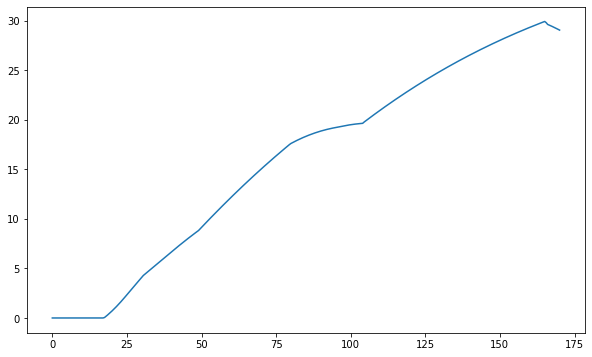

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

q=pd.read_excel("Vehicle_Normal.xlsx")  # The normal weather condition drive cycle of the car
w=pd.read_excel("Vehicle_Winter.xlsx")  # The Winter weather condition drive cycle of the car
e=pd.read_excel("Vehicle_Summer.xlsx")  # The Summer weather condition drive cycle of the car
data = pd.read_excel("Vehicle_brak.xlsx")  # The Braking  conditional road scenario

normal_data=pd.read_excel("normal.xlsx")#The Normal road condition-Data for training because 
                                         #values are not effected from any condition

bb=pd.read_excel("Vehicle_Normal.xlsx")
plt.figure(figsize=(10, 6))
plt.plot(normal_data["Time"], normal_data["Velocity"], label="ftp75")


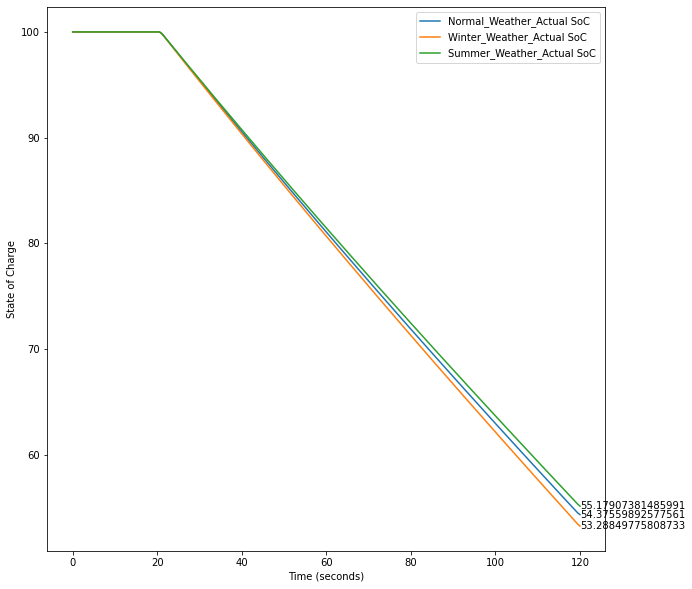

In [86]:
#Plotting and Analyzing the Effects of the Ambient Temperature on SOC



plt.figure(figsize=(10, 10))
plt.plot(q["Time"], q["SOC"], label="Normal_Weather_Actual SoC")
plt.plot(w["Time"], w["SOC"], label="Winter_Weather_Actual SoC")
plt.plot(e["Time"], e["SOC"], label="Summer_Weather_Actual SoC")
plt.xlabel('Time (seconds)')
plt.ylabel('State of Charge')
plt.legend()

last_q_soc = q["SOC"].iloc[-1]
last_w_soc = w["SOC"].iloc[-1]
last_e_soc = e["SOC"].iloc[-1]


plt.text(q["Time"].iloc[-1], last_q_soc, f'{last_q_soc}', ha='left', va='center')
plt.text(w["Time"].iloc[-1], last_w_soc, f'{last_w_soc}', ha='left', va='center')
plt.text(e["Time"].iloc[-1], last_e_soc, f'{last_e_soc}', ha='left', va='center')

plt.show()


plt.show()



Coulomb Counting Method Accuracy:
R-squared: -0.11252278602831134
RMSE: 10.87217128578442


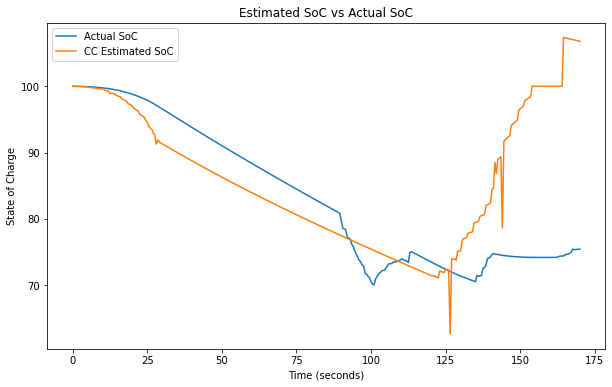

In [87]:
# first we calculate the charge
Charge= data["Current"] * (data["Time"])

# we calculate the remaining capacity
initial_capacity = 6.6 * 3600  # Replace with your battery's capacity
Capacity= initial_capacity - Charge

# then calculating  the state of charge (SoC) and turning it into percentage
CC_Estimation = Capacity / initial_capacity
CC_Estimation = CC_Estimation * 100
    
    
r2 = r2_score(data["SOC"], CC_Estimation)
rmse = np.sqrt(mean_squared_error(data["SOC"], CC_Estimation))
print("Coulomb Counting Method Accuracy:")
print("R-squared:", r2)
print("RMSE:", rmse)


# Comparision of The Actual and Estimated Soc
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["SOC"], label="Actual SoC")
plt.plot(data["Time"], CC_Estimation, label="CC Estimated SoC")
plt.title('Estimated SoC vs Actual SoC')
plt.xlabel('Time (seconds)')
plt.ylabel('State of Charge')
plt.legend()
plt.show()


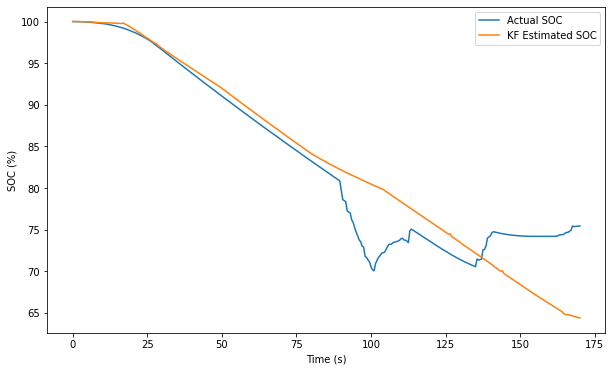

R-squared: 0.8384668671366156
RMSE: 4.142787303427752


In [88]:
# Kalman filter parameters
A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])
Q = np.array([[1e-5]])
R = np.array([[1e-7]])
x0 = np.array([[1e7]])
P0 = np.array([[1e7]])
    

    # Implementation of Kalman filter
x_k = x0
P_k = P0
x_pred = []
x_filt = []
    
for i in range(len(data)):
    # Prediction step
    x_pred_k = np.dot(A, x_k) + np.dot(B, data.iloc[i]['Current'])
    P_pred_k = np.dot(np.dot(A, P_k), A.T) + Q

    # Update step
    y_k = normal_data.iloc[i]['SOC'] - np.dot(C, x_pred_k)
    S_k = np.dot(np.dot(C, P_pred_k), C.T) + R
    K_k = np.dot(np.dot(P_pred_k, C.T), np.linalg.inv(S_k))
    x_filt_k = x_pred_k + np.dot(K_k, y_k)
    P_filt_k = np.dot((np.eye(len(x0)) - np.dot(K_k, C)), P_pred_k)

    # Save filtered SOC estimate
    x_filt.append(x_filt_k[0][0])

    # Update state and covariance matrices for next iteration
    x_k = np.array([[x_filt_k[0][0]]])
    P_k = P_filt_k
    

r2 = r2_score(data['SOC'], x_filt)
rmse = np.sqrt(mean_squared_error(data['SOC'], x_filt))
    
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['SOC'], label='Actual SOC')
plt.plot(data['Time'], x_filt, label='KF Estimated SOC')
plt.xlabel('Time (s)')
plt.ylabel('SOC (%)')
plt.legend()
plt.show()

print("R-squared:", r2)
print("RMSE:", rmse)
    

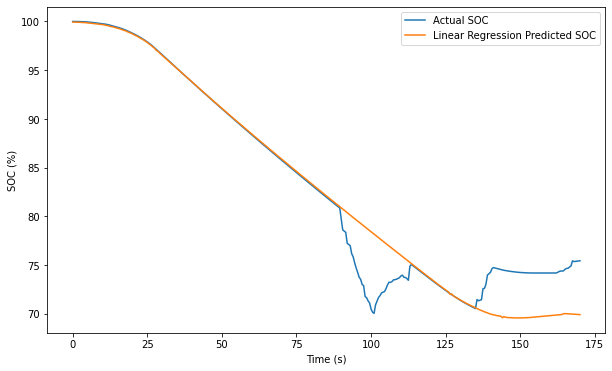

R-squared: 0.9315154554053908
RMSE: 2.6974792623419557


In [89]:
#Linear Regression For SOC Estimation

# we Split the dataset into features (X) and labels (y)
X_train = normal_data[['Voltage', 'Current', 'Cell_Temperature']] # Adjust the column names accordingly
y_train = normal_data['SOC'] # Adjust the column name accordingly

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# We add the input data we want to predict
new_X =data[['Voltage', 'Current', 'Cell_Temperature']]
#Actual SOC 
new_y =data['SOC']

# We Use the trained model to predict the SOC for the new data
new_y_pred = model.predict(new_X)

# Calculating R-squared score
r2 = r2_score(new_y, new_y_pred)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(new_y, new_y_pred))

plt.figure(figsize=(10, 6))
plt.plot(data['Time'], new_y, label='Actual SOC')
plt.plot(data['Time'], new_y_pred, label='Linear Regression Predicted SOC')
plt.xlabel('Time (s)')
plt.ylabel('SOC (%)')
plt.legend()
plt.show()


print("R-squared:", r2)
print("RMSE:", rmse)

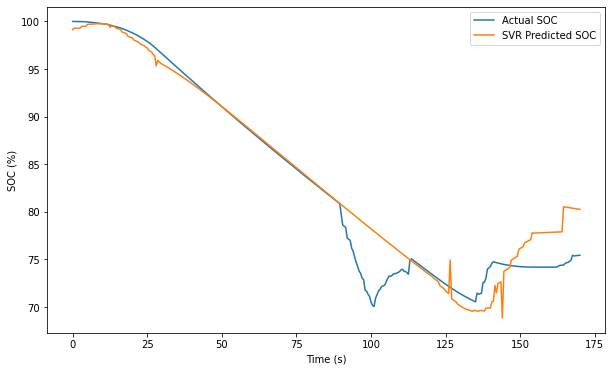

R-squared: 0.9466878766529195
RMSE: 2.3799882811230457


In [90]:
# Support Vector Regression
X_train = normal_data[['Voltage', 'Current', 'Cell_Temperature']] 
y_train = normal_data['SOC'] 

model = SVR()
model.fit(X_train, y_train)


X_new = data[['Voltage', 'Current', 'Cell_Temperature']] 
y_test = data['SOC']
y_pred = model.predict(X_new)


plt.figure(figsize=(10, 6))
plt.plot(data['Time'], y_test, label='Actual SOC')
plt.plot(data['Time'], y_pred, label='SVR Predicted SOC')
plt.xlabel('Time (s)')
plt.ylabel('SOC (%)')
plt.legend()
plt.show()

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R-squared:", r2)
print("RMSE:", rmse)


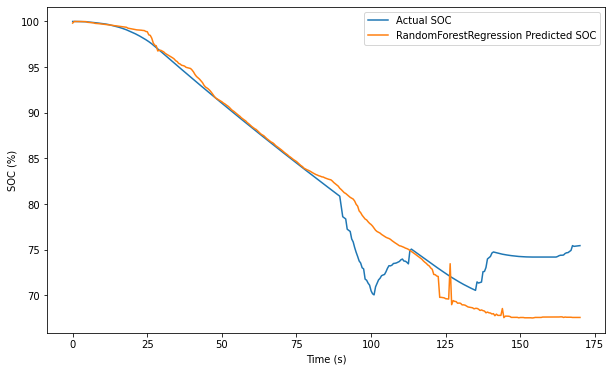

R-squared: 0.8865640556054057
RMSE: 3.471659907809398


In [91]:
# Random Forest Regression SOC Estimation
X_train = normal_data[['Voltage', 'Current', 'Cell_Temperature']] 
y_train = normal_data['SOC'] 

model = RandomForestRegressor()
model.fit(X_train, y_train)

new_X = data[['Voltage', 'Current', 'Cell_Temperature']]
new_y = data['SOC']

new_y_pred = model.predict(new_X)

r2 = r2_score(new_y, new_y_pred)
rmse = np.sqrt(mean_squared_error(new_y, new_y_pred))


plt.figure(figsize=(10, 6))
plt.plot(data['Time'], new_y, label='Actual SOC')
plt.plot(data['Time'], new_y_pred, label='RandomForestRegression Predicted SOC')
plt.xlabel('Time (s)')
plt.ylabel('SOC (%)')
plt.legend()
plt.show()


print("R-squared:", r2)
print("RMSE:", rmse)